In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from dateutil.parser import parse
import json

In [4]:
# Load data from json
with open("PNL_data.json") as json_file:
    PNL_data = json.load(json_file)

with open("POL_data.json") as json_file:
    POL_data = json.load(json_file)

# Combine and mark with up or down
combined = \
    [(event, 2 * (1 + (ix % 5))) for ix, event in enumerate(PNL_data["data"])] + \
    [(event, -2 * (1 + (ix % 5))) for ix, event in enumerate(POL_data["data"])]

# Split into labels
def to_datetime(stamp: str):
    print(stamp)
    return datetime.strptime(stamp, '%Y-%m-%d %H:%M:%S,%f')

times = [to_datetime(event["timestamp"]) for (event, _) in combined]
labels = [event["event"] for (event, _) in combined]
levels = [level for (_, level) in combined]
print(times)

2023-06-23 16:09:47,265
2023-06-23 16:09:48,430
2023-06-23 16:09:48,433
2023-06-23 16:09:48,442
2023-06-23 16:09:48,446
2023-06-23 16:09:49,505
2023-06-23 16:09:47,130
2023-06-23 16:09:47,253
2023-06-23 16:09:47,253
2023-06-23 16:09:47,354
2023-06-23 16:09:48,430
2023-06-23 16:09:50,472
2023-06-23 16:09:57,241
[datetime.datetime(2023, 6, 23, 16, 9, 47, 265000), datetime.datetime(2023, 6, 23, 16, 9, 48, 430000), datetime.datetime(2023, 6, 23, 16, 9, 48, 433000), datetime.datetime(2023, 6, 23, 16, 9, 48, 442000), datetime.datetime(2023, 6, 23, 16, 9, 48, 446000), datetime.datetime(2023, 6, 23, 16, 9, 49, 505000), datetime.datetime(2023, 6, 23, 16, 9, 47, 130000), datetime.datetime(2023, 6, 23, 16, 9, 47, 253000), datetime.datetime(2023, 6, 23, 16, 9, 47, 253000), datetime.datetime(2023, 6, 23, 16, 9, 47, 354000), datetime.datetime(2023, 6, 23, 16, 9, 48, 430000), datetime.datetime(2023, 6, 23, 16, 9, 50, 472000), datetime.datetime(2023, 6, 23, 16, 9, 57, 241000)]


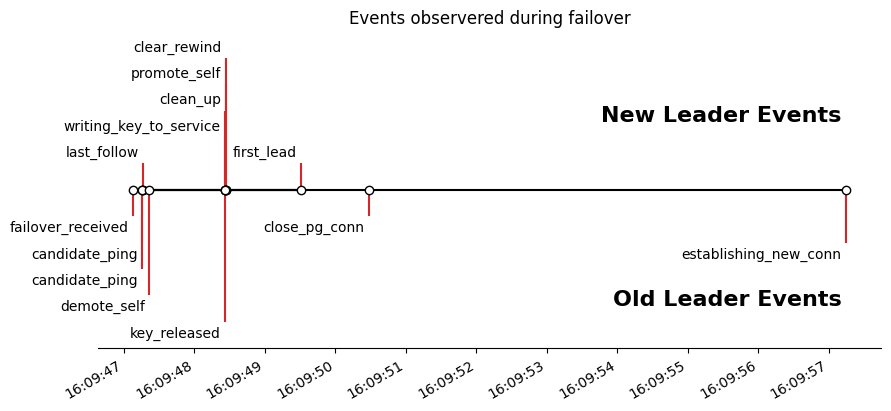

In [5]:
# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(8.8, 4), layout="constrained")
ax.set(title="Events observered during failover")

ax.vlines(times, 0, levels, color="tab:red")  # The vertical stems.
ax.plot(times, np.zeros_like(times), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.

# annotate lines
for d, l, r in zip(times, levels, labels):
    ax.annotate(r, xy=(d, l),
                xytext=(-3, np.sign(l)*3), textcoords="offset points",
                horizontalalignment="right",
                verticalalignment="bottom" if l > 0 else "top")

# format x-axis with 4-month intervals
ax.xaxis.set_major_locator(mdates.SecondLocator(interval=1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# Hand draw above/below labels for clarity
ax.annotate("New Leader Events", xy=(times[-1], 6),
                xytext=(-3,4), textcoords="offset points",
                weight="bold",
                fontsize=16,
                horizontalalignment="right",
                verticalalignment="top")

ax.annotate("Old Leader Events", xy=(times[-1], -8),
                xytext=(-3,4), textcoords="offset points",
                weight="bold",
                fontsize=16,
                horizontalalignment="right",
                verticalalignment="top")

# remove y-axis and spines
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(y=0.1)
plt.show()

In [6]:
# Now load the data about writes from the client's perspective

with open("ClientPerspective.json") as json_file:
    client_data = json.load(json_file)

client_times: list[datetime] = []
for entry in client_data:
    client_times.append(parse(entry['time']))

biggest_gap = -1
gap_ix = -1
for ix in range(len(client_times) - 1):
    this_time = client_times[ix]
    next_time = client_times[ix + 1]
    this_gap = (next_time - this_time).seconds
    if this_gap > biggest_gap:
        biggest_gap = this_gap
        gap_ix = ix

49


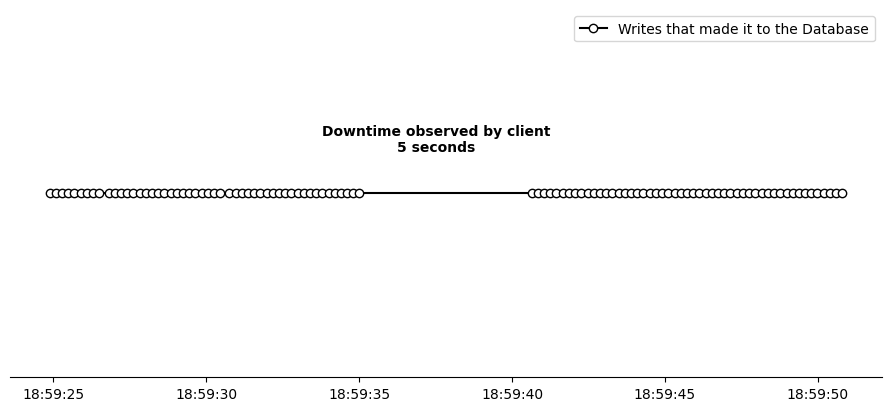

In [7]:
# Make a simple graph to show the downtime perceived by the client

fig, ax = plt.subplots(figsize=(8.8, 4), layout="constrained")
# ax.set(title="Events observered during failover")

ax.vlines(client_times, 0, [0 for thing in client_times], color="tab:red")  # The vertical stems.
ax.plot(client_times, np.zeros_like(client_times), "-o",
        color="k", markerfacecolor="w", label="Writes that made it to the Database")

# Hand draw label for client gap
print(gap_ix)
ax.annotate(f"Downtime observed by client\n{biggest_gap} seconds", xy=(client_times[gap_ix] + timedelta(seconds=biggest_gap / 2), 0),
                xytext=(0,50), textcoords="offset points",
                weight="bold",
                fontsize=10,
                horizontalalignment="center",
                verticalalignment="top")

ax.legend()

# remove y-axis and spines
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(y=0.1)
plt.show()

In [11]:
def to_datetime_comma(stamp: str):
    # Get a datetime from a string in our logs
    return datetime.strptime(stamp, '%Y-%m-%d %H:%M:%S,%f')

def to_datetime_period(stamp: str):
    # Get a datetime from a string in our logs
    return datetime.strptime(stamp, '%Y-%m-%d %H:%M:%S.%f')

def load_events(file: str):
    with open(file) as json_file:
        return json.load(json_file)["data"]

def plot_events(old_events, new_events, title: str, convert_func):
    # Plot an event (presumably from a source)
    old_staggers = [-x for x in range(1,8)]
    old_labels = [event["readable"] for event in old_events]
    old_levels = [old_staggers[ix % len(old_staggers)] for ix in range(len(old_labels))]
    old_times = [convert_func(event["timestamp"]) for event in old_events]

    new_staggers = [x for x in range(1,8)]
    new_labels = [event["readable"] for event in new_events]
    new_levels = [new_staggers[ix % len(new_staggers)] for ix in range(len(new_labels))]
    new_times = [convert_func(event["timestamp"]) for event in new_events]

    fig, ax = plt.subplots(figsize=(8.8, 4), layout="constrained")
    ax.set(title=title)

    labels = old_labels + new_labels
    levels = old_levels + new_levels
    times = old_times + new_times
    print(times)

    ax.vlines(times, 0, levels, color="tab:red")
    ax.plot(times, np.zeros_like(times), "-o",
            color="k", markerfacecolor="w")
    
    for d, l, r in zip(times, levels, labels):
        ax.annotate(r, xy=(d,l), xytext=(-3, np.sign(l)*3), textcoords="offset points",
                    horizontalalignment="right",
                    verticalalignment="bottom" if l > 0 else "top")
    
    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=1))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    # Hand draw above/below labels for clarity
    ax.annotate("New Leader Events", xy=(max(times), 6),
                    xytext=(-3,4), textcoords="offset points",
                    weight="bold",
                    fontsize=16,
                    horizontalalignment="right",
                    verticalalignment="top")

    ax.annotate("Old Leader Events", xy=(max(times), -5),
                    xytext=(-3,4), textcoords="offset points",
                    weight="bold",
                    fontsize=16,
                    horizontalalignment="right",
                    verticalalignment="top")

    # remove y-axis and spines
    ax.yaxis.set_visible(False)
    ax.spines[["left", "top", "right"]].set_visible(False)

    ax.margins(y=0.1)
    plt.show()

[datetime.datetime(2023, 6, 23, 16, 9, 47, 130000), datetime.datetime(2023, 6, 23, 16, 9, 47, 253000), datetime.datetime(2023, 6, 23, 16, 9, 47, 253000), datetime.datetime(2023, 6, 23, 16, 9, 47, 354000), datetime.datetime(2023, 6, 23, 16, 9, 48, 430000), datetime.datetime(2023, 6, 23, 16, 9, 50, 472000), datetime.datetime(2023, 6, 23, 16, 9, 57, 241000), datetime.datetime(2023, 6, 23, 16, 9, 47, 265000), datetime.datetime(2023, 6, 23, 16, 9, 48, 430000), datetime.datetime(2023, 6, 23, 16, 9, 48, 433000), datetime.datetime(2023, 6, 23, 16, 9, 48, 442000), datetime.datetime(2023, 6, 23, 16, 9, 48, 446000), datetime.datetime(2023, 6, 23, 16, 9, 49, 505000)]


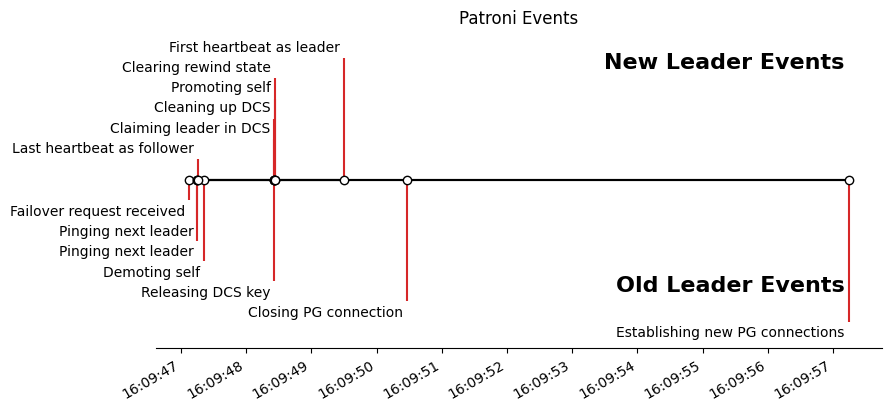

[datetime.datetime(2023, 6, 23, 20, 43, 1, 674000), datetime.datetime(2023, 6, 23, 20, 43, 18, 611000), datetime.datetime(2023, 6, 23, 20, 43, 18, 650000), datetime.datetime(2023, 6, 23, 20, 43, 22, 9000), datetime.datetime(2023, 6, 23, 20, 43, 22, 23000), datetime.datetime(2023, 6, 23, 20, 43, 5, 452000), datetime.datetime(2023, 6, 23, 20, 43, 5, 458000), datetime.datetime(2023, 6, 23, 20, 43, 19, 660000), datetime.datetime(2023, 6, 23, 20, 43, 19, 662000), datetime.datetime(2023, 6, 23, 20, 43, 19, 726000)]


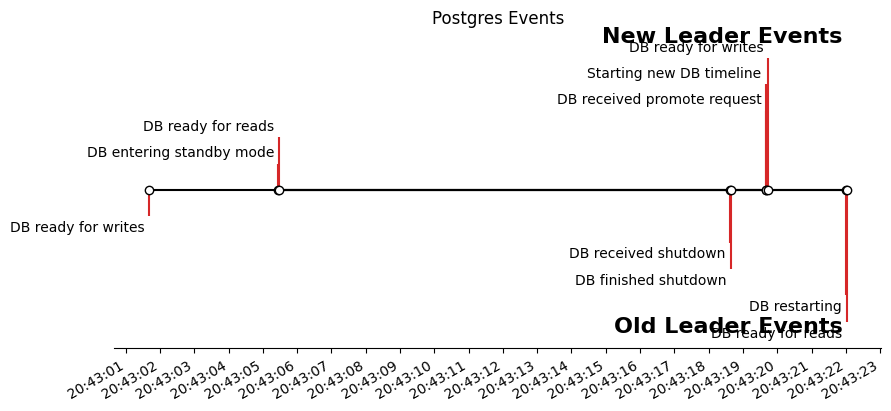

In [12]:
POL_events = load_events("POL_data.json")
PNL_events = load_events("PNL_data.json")
plot_events(POL_events, PNL_events, title="Patroni Events", convert_func=to_datetime_comma)
GOL_events = load_events("GOL_data.json")
GNL_events = load_events("GNL_data.json")
plot_events(GOL_events, GNL_events, title="Postgres Events", convert_func=to_datetime_period)